<a href="https://colab.research.google.com/github/Farheen-Banu26/AiLab/blob/main/CustomerReviewSentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# CUSTOMER REVIEW SENTIMENT ANALYSIS

In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import re
from collections import Counter
from wordcloud import WordCloud

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ML Libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Handling class imbalance
from imblearn.over_sampling import SMOTE

# For saving models
import joblib
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Step 2: Load Dataset
file_path = "NLP dataset csv.csv"  # Update with your file path
# Added engine='python' to handle potential parsing errors
df = pd.read_csv(file_path, on_bad_lines='skip', engine='python')

# Basic info
print("🔹 First 5 rows:")
print(df.head())
print("\n Dataset Info:")
print(df.info())
print("\n Dataset Shape:", df.shape)

🔹 First 5 rows:
                     id       asins   brand                  categories  \
0  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
1  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
2  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
3  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   
4  AVpe7AsMilAPnD_xQ78G  B00QJDU3KY  Amazon  Amazon Devices,mazon.co.uk   

  colors             dateAdded           dateUpdated  \
0    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
1    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
2    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
3    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   
4    NaN  2016-03-08T20:21:53Z  2017-07-18T23:52:58Z   

                  dimension  ean                         keys  ...  \
0  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qjdu3ky  ...   
1  169 mm x 117 mm x 9.1 mm  NaN  kindlepaperwhite/b00qj

In [4]:
# Step 3: Check Missing Values
print("\n❌ Missing Values per Column:")
print(df.isnull().sum())

# Step 4: Select Relevant Columns and Clean Data
df = df[['reviews.text','reviews.rating','reviews.doRecommend','reviews.numHelpful']]

# Drop missing text or rating
df = df.dropna(subset=['reviews.text','reviews.rating'])

# Drop duplicate reviews
df = df.drop_duplicates(subset=['reviews.text'])

# Reset index
df.reset_index(drop=True, inplace=True)

# Rename columns
df = df.rename(columns={
    'reviews.text': 'text',
    'reviews.rating': 'rating',
    'reviews.doRecommend': 'doRecommend',
    'reviews.numHelpful': 'numHelpful'
})

# Fill missing values and ensure correct types
df['doRecommend'] = df['doRecommend'].fillna(False).astype(bool)
df['numHelpful'] = df['numHelpful'].fillna(0).astype(int)
df['rating'] = df['rating'].astype(float)

# Reset index again
df.reset_index(drop=True, inplace=True)

print("\n✅ Final Cleaned Data Preview:")
print(df.head())


❌ Missing Values per Column:
id                         0
asins                      0
brand                      0
categories                 0
colors                   823
dateAdded                  0
dateUpdated                0
dimension               1032
ean                      699
keys                       0
manufacturer             632
manufacturerNumber       695
name                       0
prices                     0
reviews.date             380
reviews.doRecommend     1058
reviews.numHelpful       697
reviews.rating           420
reviews.sourceURLs         0
reviews.text               0
reviews.title             17
reviews.userCity        1597
reviews.userProvince    1597
reviews.username          17
sizes                   1597
upc                      699
weight                   911
dtype: int64

✅ Final Cleaned Data Preview:
                                                text  rating  doRecommend  \
0  I initially had trouble deciding between the p...     5.0      

In [5]:
# Step 5: Create Sentiment Labels
def label_sentiment(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

df['sentiment'] = df['rating'].apply(label_sentiment)
print("\n🎯 Sentiment Distribution:")
print(df['sentiment'].value_counts())


🎯 Sentiment Distribution:
sentiment
Positive    766
Negative     72
Neutral      70
Name: count, dtype: int64


In [6]:
# Step 6: Text Preprocessing with Advanced Negation Handling
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
NEGATION_WORDS = {"not", "no", "never"}

def clean_text_with_negation(text, window=3):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = nltk.word_tokenize(text)

    new_tokens = []
    i = 0
    while i < len(tokens):
        if tokens[i] in NEGATION_WORDS:
            # Grab up to `window` words after negation
            neg_phrase = [tokens[i]]
            for j in range(1, window+1):
                if i+j < len(tokens):
                    neg_phrase.append(tokens[i+j])
                else:
                    break
            # Combine negation phrase into one token
            new_tokens.append("_".join(neg_phrase))
            i += len(neg_phrase)
        else:
            new_tokens.append(tokens[i])
            i += 1

    # Remove stopwords and lemmatize
    new_tokens = [lemmatizer.lemmatize(w) for w in new_tokens if w not in stop_words]
    return " ".join(new_tokens)

df['clean_text'] = df['text'].apply(clean_text_with_negation)
df['review_length'] = df['clean_text'].apply(lambda x: len(x.split()))
print("\n✅ Cleaned Text Preview:")
print(df[['text','clean_text']].head())


✅ Cleaned Text Preview:
                                                text  \
0  I initially had trouble deciding between the p...   
1  Allow me to preface this with a little history...   
2  I am enjoying it so far. Great for reading. Ha...   
3  I bought one of the first Paperwhites and have...   
4  I have to say upfront - I don't like coroporat...   

                                          clean_text  
0  initially trouble deciding paperwhite voyage r...  
1  allow preface little history casual reader own...  
2  enjoying far great reading original fire since...  
3  bought one first paperwhites pleased constant ...  
4  say upfront dont like coroporate hermetically ...  


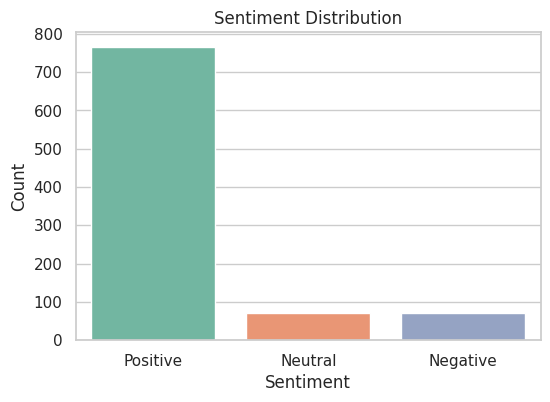

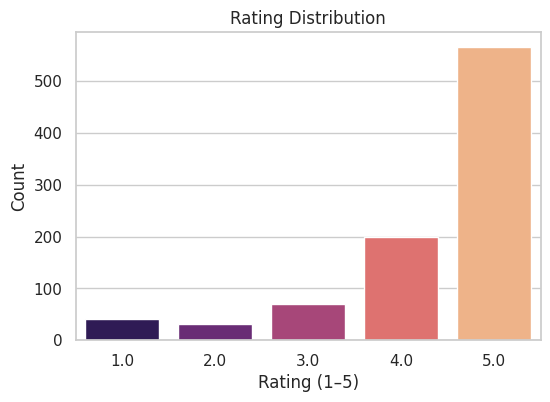

In [7]:
# Step 7: EDA – Sentiment & Rating Distributions
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df, palette="Set2")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='rating', data=df, palette="magma")
plt.title("Rating Distribution")
plt.xlabel("Rating (1–5)")
plt.ylabel("Count")
plt.show()

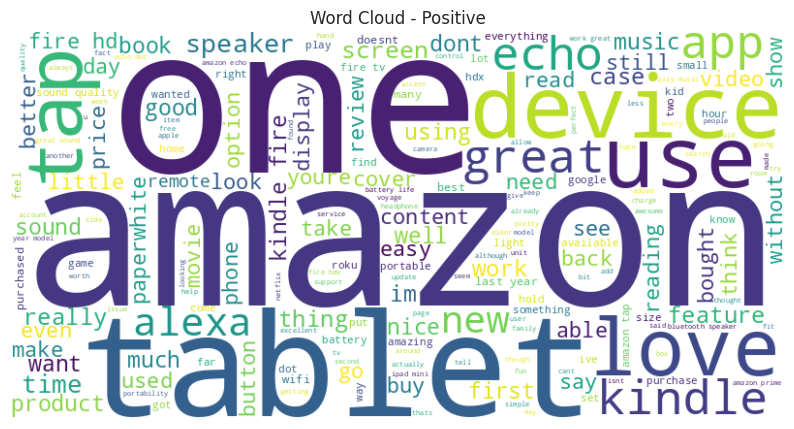

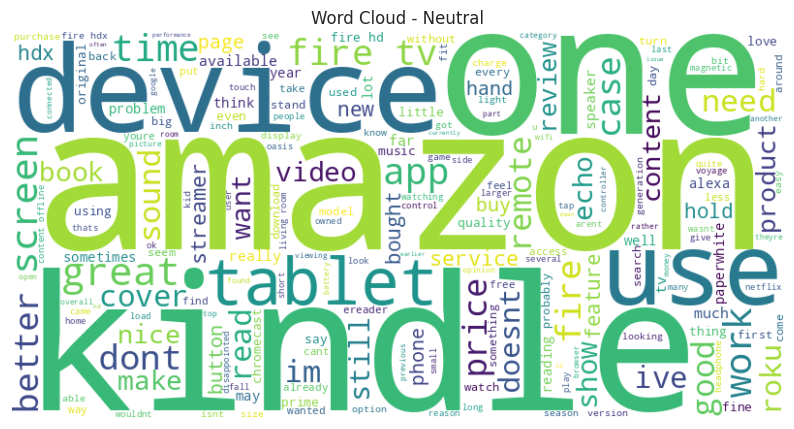

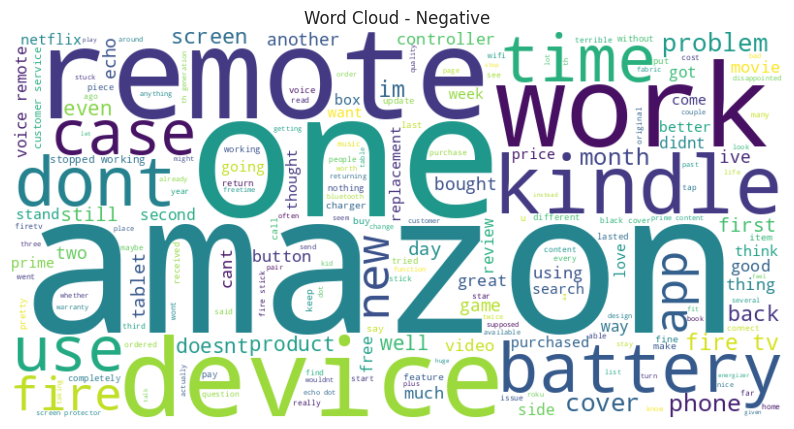

In [8]:
# Step 8: Word Clouds per Sentiment
def plot_wordcloud(sentiment):
    text = " ".join(df[df['sentiment']==sentiment]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {sentiment}")
    plt.show()

for s in ["Positive","Neutral","Negative"]:
    plot_wordcloud(s)


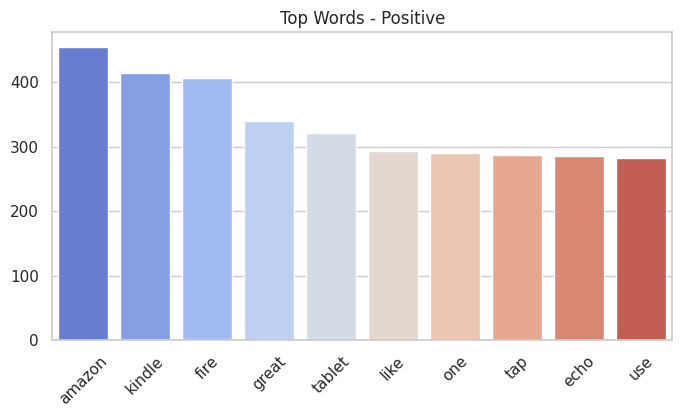

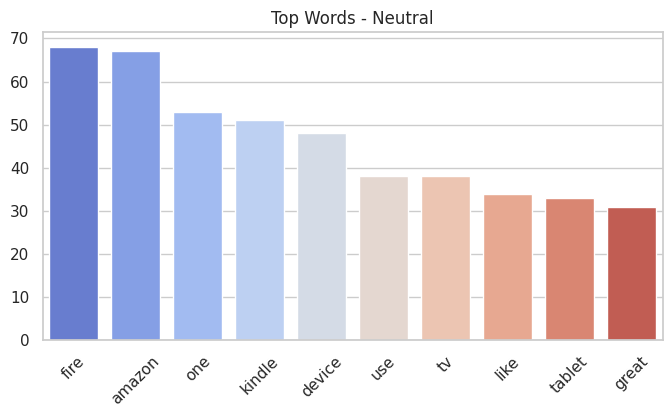

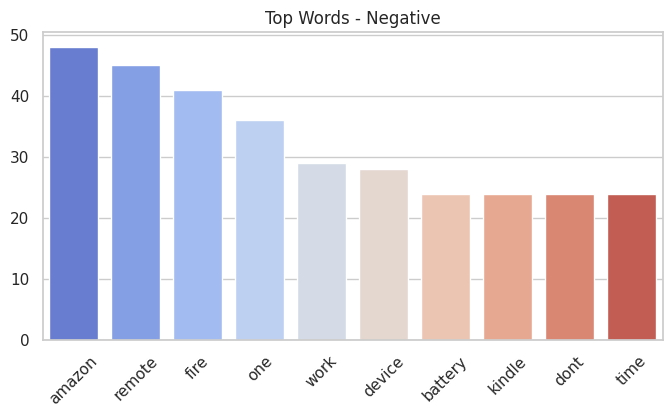

In [9]:
# Step 9: Most Frequent Words (Unigrams)
def get_top_n_words(corpus, n=10):
    tokens = [word for text in corpus for word in text.split()]
    counter = Counter(tokens)
    return counter.most_common(n)

for s in ["Positive","Neutral","Negative"]:
    top_words = get_top_n_words(df[df['sentiment']==s]['clean_text'], 10)
    words, counts = zip(*top_words)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(words), y=list(counts), palette="coolwarm")
    plt.title(f"Top Words - {s}")
    plt.xticks(rotation=45)
    plt.show()

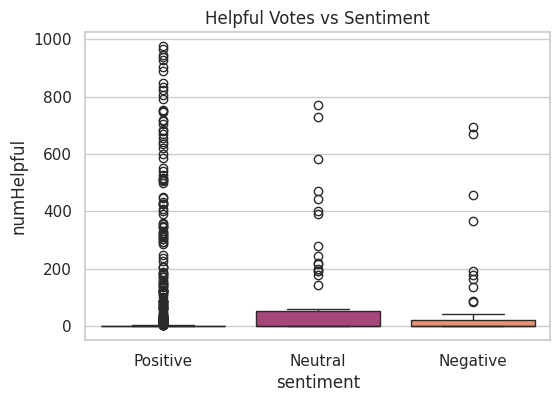

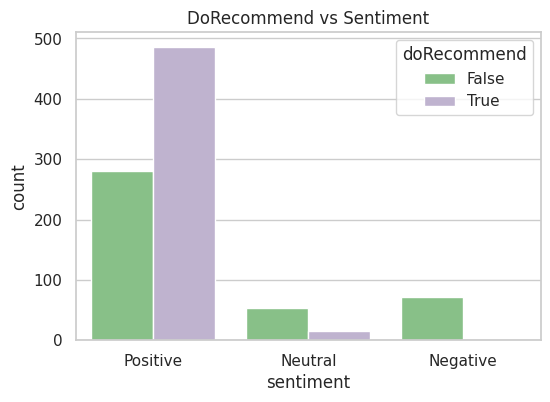

In [10]:

# Step 10: Helpful Votes & DoRecommend Insights
plt.figure(figsize=(6,4))
sns.boxplot(x='sentiment', y='numHelpful', data=df, palette="magma")
plt.title("Helpful Votes vs Sentiment")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', hue='doRecommend', data=df, palette="Accent")
plt.title("DoRecommend vs Sentiment")
plt.show()

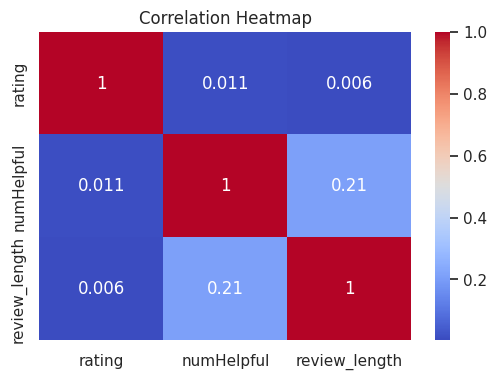

In [11]:
# Step 11: Correlation Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df[['rating','numHelpful','review_length']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [12]:
# Step 12: Top Bigrams & Trigrams per Sentiment
def get_top_ngrams(corpus, ngram_range=(2,3), top_n=15):
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(corpus)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:top_n]

for sentiment in ['Positive','Neutral','Negative']:
    corpus = df[df['sentiment'] == sentiment]['clean_text']
    print(f"\nTop Bigrams & Trigrams for {sentiment} Reviews:")
    top_ngrams = get_top_ngrams(corpus)
    for ngram, freq in top_ngrams:
        print(f"{ngram} → {freq}")


Top Bigrams & Trigrams for Positive Reviews:
sound quality → 59
amazon tap → 54
bluetooth speaker → 47
kindle hd → 46
amazon prime → 42
battery life → 39
work great → 37
amazon echo → 36
echo dot → 35
great sound → 35
play music → 33
ipad mini → 32
year model → 32
easy use → 30
kindle paperwhite → 28

Top Bigrams & Trigrams for Neutral Reviews:
content offline → 6
living room → 6
want read → 5
work great → 5
th generation → 5
echo dot → 5
amazon prime → 4
ability watch → 4
watch content → 4
ability watch content → 4
watch content offline → 4
inch tv → 4
battery life → 4
great sound → 4
voice search → 4

Top Bigrams & Trigrams for Negative Reviews:
voice remote → 9
stopped working → 8
customer service → 8
new kindle → 5
black cover → 5
prime movie → 4
prime content → 4
doesnt work → 4
th generation → 4
echo dot → 4
screen protector → 4
replacement remote → 4
battery life → 3
aa battery → 3
netflix app → 3


In [13]:
# Step 13: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(df['clean_text'])
y = df['sentiment']
print("✅ TF-IDF Created")
print("TF-IDF shape:", X_tfidf.shape)

✅ TF-IDF Created
TF-IDF shape: (908, 2000)


In [14]:
# Step 14: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_tfidf, y)
print("Resampled dataset shape:", Counter(y_res))

Resampled dataset shape: Counter({'Positive': 766, 'Neutral': 766, 'Negative': 766})


In [15]:
# Step 15: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)
print("✅ Data split done!")
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


✅ Data split done!
Training samples: 1838
Testing samples: 460


In [16]:
# Step 16: Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predict
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("✅ Random Forest Model Trained!\n")
print("🎯 Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\n🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

✅ Random Forest Model Trained!

🎯 Accuracy: 0.9565217391304348

📊 Classification Report:
               precision    recall  f1-score   support

    Negative       0.96      0.98      0.97       153
     Neutral       0.97      0.96      0.97       153
    Positive       0.94      0.93      0.93       154

    accuracy                           0.96       460
   macro avg       0.96      0.96      0.96       460
weighted avg       0.96      0.96      0.96       460


🔍 Confusion Matrix:
 [[150   0   3]
 [  0 147   6]
 [  7   4 143]]


In [17]:
# Step 17: Save Model & Vectorizer
joblib.dump(rf_model, "rf_sentiment_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")
print("✅ Model and vectorizer saved successfully!")

✅ Model and vectorizer saved successfully!


In [18]:
# Step 18: Interactive Prediction Demo
# Load saved model and vectorizer
model = joblib.load("rf_sentiment_model.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")

In [19]:
# Example interactive input
review = input("Enter a product review: ")
cleaned_review = clean_text_with_negation(review)
vect_review = vectorizer.transform([cleaned_review])
prediction = model.predict(vect_review)[0]
print(f"Predicted Sentiment: {prediction}")

Enter a product review: good
Predicted Sentiment: Positive
